In [12]:
import pandas as pd
import numpy as np
import os 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.utils as utils
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.image as mpimg
from torchvision import models

import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

## 8 Class Classification Problem 

Initially work on trying to classifiy based on google search scraped pictures of these lightbulbs.
The problem with this is that they nearly always have a white backgroud and are not realistic of a phone camera version
of a picture of the light bulb

Classes<br>
E27 light bulbs<br>
E14 light bulbs<br>
B22 light bulbs<br>
B15 light bulbs<br>
GU10 light bulbs<br>
G4<br>
G9<br>
MR16<br>


Need to also buy some examples of the light bulbs and take pictures on my phone as a way of building up my own dataset that might be more realistic.


# Support functions

In [13]:
folders = ['B15','B22','E14', 'E27', 'G4', 'G9','GU10', 'MR16']

def file_rename(folders):
    '''
    Function to rename all files taken from the internet from training.Used to rename
    all the file names to avoid really long file names and make it easier to know which
    bulb it is.
    
    Could be made more generic for other projects. Eg move out the base location into a parameter.
    
    input - folder names
    
    output - all files renamed in place. 
    
    '''
    
    for bulb_type in folders:

        location = r"C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data"
        location = location + '\\' + bulb_type + '\\'
        print(location)
        for count, filename in enumerate(os.listdir(location)): 
            dst = bulb_type + str(count) + ".jpg"
            src = location + filename 
            dst = location + dst 
            # rename() function will 
            # rename all the files 
            os.rename(src, dst) 

In [14]:
def create_separate_train_dev_test( dataset, percentages = [0.8,0.1,0.1]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    # Add in test to check for this ~
    
    Outputs - each dataloader.
    
    '''

    indices = list(range(len(dataset)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(dataset)*0.8))
    split_2 = int(np.floor(len(dataset)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(dataset,
                                                 batch_size=64,
                                                 num_workers=0 , sampler = train_sampler)

    dataloader_dev = torch.utils.data.DataLoader(dataset,
                                                 batch_size=1,
                                                 num_workers=0 , sampler = dev_sampler)

    dataloader_test = torch.utils.data.DataLoader(dataset,
                                                 batch_size=1,
                                                 num_workers=0 , sampler = test_sampler)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [15]:
def print_examples(dataloader, number_to_show =4):
    i=0
    for x, y in dataloader:  
        # Can't get it to effectively print out the images in the notebook. I think it might be something to do with the numpy conversion above.
        '''
        out = np.reshape(x[i].numpy(),newshape =[x[i].shape[1],x[i].shape[2],x[i].shape[0]])
        plt.imshow(out)
        plt.title('Bulb type {}'.format(y[i]))
        plt.show()
        '''
        # Instead going to save and reload
        vutils.save_image(x[0], '%s_example.png' % i, normalize = True)
        
        image = mpimg.imread('%s_example.png' % i)
        plt.imshow(image)
        plt.show()
        i = i + 1
        if i == number_to_show:
            break

# Datasets

In [36]:
# Create a pytorch dataset, and then dataloader to allow for mini-batch processing. 
# We can't really use random crops as it might cut off the connector

data_transform = transforms.Compose([
        transforms.Resize((64,64)),
        #ransforms.CenterCrop(128),
        #transforms.RandomSizedCrop(2000),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
light_bulbs = datasets.ImageFolder(root=r'C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data',
                                           transform=data_transform)
    

In [37]:
train, dev, test = create_separate_train_dev_test(light_bulbs, percentages = [0.8,0.1,0.1])

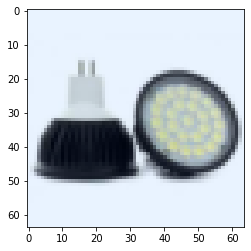

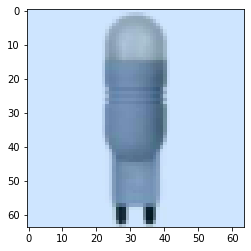

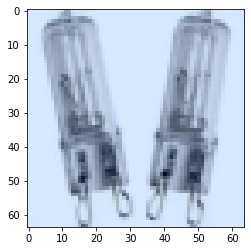

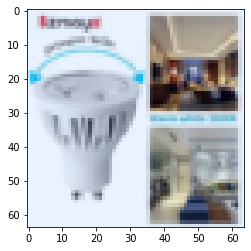

In [38]:
print_examples(train, number_to_show =4)

# CNN

In [19]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [20]:
# You don't actually need to do this with pytorch but sometime useful to know what's happening. 
# Calculate Hout of layer
def output_sizes(hin, win, padding, dilation, kernal, stride):
    hout = ((hin + (2*padding[0]) - (dilation[0] * (kernal[0] -1)) - 1)/stride[0]) + 1

    # Calculate Wout of layer

    wout = ((win + (2*padding[1]) - (dilation[1] * (kernal[1] -1)) - 1)/stride[1]) + 1
    print('hout {}'.format(hout))
    print('hout {}'.format(wout))

In [21]:
output_sizes(64, 64, padding = [1,1], dilation = [0,0], kernal = [4,4], stride = [1,1])

hout 66.0
hout 66.0


In [22]:
# Adding this custom class so when you're building out the sequential model in pytorch you can print out the size of each layer.
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        #print('Layer_print {}'.format(x.shape))
        return x

In [23]:
# Define the classifier

class bulb_model(nn.Module):
    
    def __init__(self):
        super(bulb_model, self).__init__()
    
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #PrintLayer(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            #PrintLayer(),
            # add a max pooling layer
            nn.MaxPool2d(kernel_size =3 , stride=1, padding=0),
            #PrintLayer(),
            nn.BatchNorm2d(128),
            PrintLayer(),
            nn.LeakyReLU(0.2, inplace = True), 
            #PrintLayer(),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            #PrintLayer(),
            nn.MaxPool2d(kernel_size =2 , stride=1, padding=0),
            #PrintLayer(),
            nn.BatchNorm2d(256), 
            PrintLayer(),
            nn.LeakyReLU(0.2, inplace = True), 
            #PrintLayer(),
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            #PrintLayer(),
            nn.BatchNorm2d(512), 
            #PrintLayer(),
            nn.LeakyReLU(0.2, inplace = True), 
            #PrintLayer(),
            nn.Conv2d(512, 10, 4, 1, 0, bias = False), 
            #PrintLayer(),
            nn.Flatten(),
            #PrintLayer(),
            nn.Linear(90, 128),
            #PrintLayer(),
            nn.Dropout(p=0.2),
            #PrintLayer(),
            nn.Linear(128, 10),
            nn.Softmax()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [24]:
classifier_1 = bulb_model()
classifier_1.apply(weights_init)

bulb_model(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PrintLayer()
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): PrintLayer()
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

# Train classifier

In [313]:
# create an optimiser for the classifier
optimiser_bulb = optim.Adam(classifier_1.parameters(), lr=0.01, betas = (0.9,0.999))
# Create a criterion. Lets use cross entropy loss. 
criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

In [314]:
epochs_total = 50

In [315]:
error_monitoring = []

for epoch in range(epochs_total):
    i = 1
    for data, labels in train:
         
        #print(data.shape)    
        # push the image through the network
        prediction = classifier_1(data)
        
        error = criterion(prediction, labels)
        #print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
  
        # zero grad
        classifier_1.zero_grad()
        error.backward()
        optimiser_bulb.step()
        
        #if i == 10:
        #   break
            
        i = i + 1
    #for each epoch record the final error
    error_monitoring.append(error)
    print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))

[0/50][58/57] Loss: 2.4611
[1/50][58/57] Loss: 2.1754
[2/50][58/57] Loss: 2.4611
[3/50][58/57] Loss: 2.1754
[4/50][58/57] Loss: 2.4611
[5/50][58/57] Loss: 2.1754
[6/50][58/57] Loss: 2.3183
[7/50][58/57] Loss: 2.1754
[8/50][58/57] Loss: 2.3183
[9/50][58/57] Loss: 2.3183
[10/50][58/57] Loss: 2.4611
[11/50][58/57] Loss: 2.4611
[12/50][58/57] Loss: 2.3183
[13/50][58/57] Loss: 2.3183
[14/50][58/57] Loss: 2.1754
[15/50][58/57] Loss: 2.3183
[16/50][58/57] Loss: 2.1754
[17/50][58/57] Loss: 2.4611
[18/50][58/57] Loss: 2.0326
[19/50][58/57] Loss: 2.4611
[20/50][58/57] Loss: 2.3183
[21/50][58/57] Loss: 2.3183
[22/50][58/57] Loss: 2.1754
[23/50][58/57] Loss: 2.4611
[24/50][58/57] Loss: 2.3183
[25/50][58/57] Loss: 2.4611
[26/50][58/57] Loss: 2.1754
[27/50][58/57] Loss: 2.3183
[28/50][58/57] Loss: 2.4611
[29/50][58/57] Loss: 2.4611
[30/50][58/57] Loss: 2.0326
[31/50][58/57] Loss: 2.3183
[32/50][58/57] Loss: 2.3183
[33/50][58/57] Loss: 2.0326
[34/50][58/57] Loss: 2.4611
[35/50][58/57] Loss: 2.0326
[3

In [25]:
# confusion matrix on the dev set
# F1 score - going to be my key metric? (for now)

def inference(model, dev_dataset):

    dev_predictions = []
    dev_labels = []

    for data, labels in dev_dataset:
            # push the image through the network
            predictions = model(data).detach().numpy()
            #print(predictions)
            index  = np.argmax(predictions, axis=1)
            #print(index)
            dev_predictions.append(index)
            actual = labels.detach().numpy()
            dev_labels.append(actual)

    print(confusion_matrix(dev_labels, dev_predictions))

    from sklearn.metrics import precision_score, recall_score
    pre = precision_score(dev_labels, dev_predictions, average='micro')
    print('Precision {}'.format(round(pre,3)))
    rec = recall_score(dev_labels, dev_predictions, average='micro')
    print('Recall {}'.format(round(rec,3)))

In [317]:
inference(classifier_1, dev)

[[ 0  0 50  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0]
 [ 0  0 52  0  0  0  0  0]
 [ 0  0 75  0  0  0  0  0]
 [ 0  0 53  0  0  0  0  0]
 [ 0  0 46  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0]]
Precision 0.111
Recall 0.111


# Experimenting with Built from Scratch

Base set up - after 25 epochs it predicts them all to be type 3.

What's the problem - high bias

Bigger network,
change the learning rate
change the layers



# Transfer Learning

In [18]:
# To try and give myself a heads start lets see what happens if we use VGG network as the basis and then transfer learn. 

In [26]:
'''
Need to think carefully about the number of layers to retrain. Only want to keep the earlier layers
The bigger the difference between our domain and the domain of the pretrained network the more we need to retrain. 
'''
def retrainable_setup(model ,layers_limit):

    '''
    Function that allows you to set certain layers to be trainable or not
    When using a transfer learning approach can vary the amount of layers you want to retrain.
    
    input 
    - layers_limit - number of layers to keep fixed.
    - model 
    
    output 
    - model - with layers set for training or not. 
    '''

    for param in model.parameters():
        param.requires_grad = False
    i = 0
    for child in model.children():
        for layer in child.children():
            i  +=1
            if i > layers_limit:
                for param in layer.parameters():
                    param.requires_grad = True
            else:
                for param in layer.parameters():
                    param.requires_grad = False


In [27]:
modelVGG = models.vgg16(pretrained=True)

In [28]:
modelVGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
modelVGG.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 8),                   
                      nn.Softmax(dim=1))

In [30]:
modelVGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
model = modelVGG

In [32]:
retrainable_setup(model ,layers_limit = 27)

In [33]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,432 total parameters.
122,956,552 training parameters.


In [34]:
# create an optimiser for the classifier
optimiser_bulb_transfer = optim.Adam(model.parameters(), lr=0.01, betas = (0.9,0.999))
# Create a criterion. Lets use cross entropy loss. 
criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

In [334]:
epochs_total = 25
for epoch in range(epochs_total):
    i = 1
    for data, labels in train:
     
        # push the image through the network
        prediction = model(data)
        
        error = criterion(prediction, labels)
        #print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
  
        # zero grad
        model.zero_grad()
        error.backward()
        optimiser_bulb_transfer.step()
        
        #if i == 10:
        #   break
            
        i = i + 1
    #for each epoch record the final error
    error_monitoring.append(error)
    print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))

[0/1][58/57] Loss: 2.2740


In [335]:
inference(model, dev)

[[ 0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  1 51  0]
 [ 0  0  0  1  0  0 74  0]
 [ 0  0  0  0  0  0 53  0]
 [ 0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0 80  0]]
Precision 0.102
Recall 0.102


# Hyperparameter Testing 

In [ ]:
# Testing different parameters. 

# Learning Rate

epochs_total = 25

results = {}

for learning_rate in [0.01,0.001,0.0001]:
    modelVGG = models.vgg16(pretrained=True)
    modelVGG.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 8),                   
                      nn.Softmax(dim=1))
    retrainable_setup(modelVGG ,layers_limit = 27)
    # create an optimiser for the classifier
    optimiser_bulb_transfer = optim.Adam(model.parameters(), lr=learning_rate, betas = (0.9,0.999))
    # Create a criterion. Lets use cross entropy loss. 
    criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
    error_monitoring = []
    
    for epoch in range(epochs_total):
        i = 1
        for data, labels in train:

            # push the image through the network
            prediction = modelVGG(data)

            error = criterion(prediction, labels)

            # zero grad
            model.zero_grad()
            error.backward()
            optimiser_bulb_transfer.step()
            
            i = i + 1
        #for each epoch record the final error
        error_monitoring.append(error.item())
        print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
    
    results[learning_rate] = error_monitoring
        

[0/25][54/53] Loss: 2.0838
[1/25][54/53] Loss: 2.0940
[2/25][54/53] Loss: 2.0589
[3/25][54/53] Loss: 2.1079
[4/25][54/53] Loss: 2.1013
[5/25][54/53] Loss: 2.0673
[6/25][54/53] Loss: 2.0871
[7/25][54/53] Loss: 2.0815


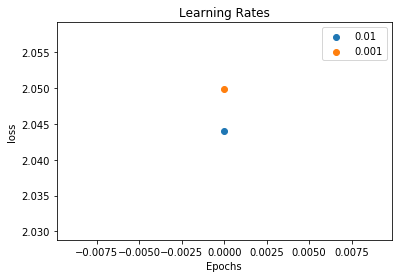

In [11]:
x_values = list(range(0,epochs_total))
for learning_rate in [0.01,0.001,0.0001]:
    plt.scatter(x_values, results[learning_rate], label=learning_rate)

    plt.title('Learning Rates')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()